In [79]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [80]:
load_dotenv()

True

In [81]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

In [82]:
class SentimentSchema(BaseModel):

    sentiment: Literal['positive', 'negetive'] = Field(description='Sentiment of the review')

In [83]:
class DiagnosisSchema(BaseModel):
    
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [84]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [85]:
# Create state
class ReviewState(TypedDict):

    review: str
    sentiment: str
    diagnosis: dict
    response: str
    

In [86]:
# functions
def find_sentiment(state: ReviewState):

    prompt = f'Based on given review perform a sentiment analysis. \n {state['review']}'

    sentiment = structured_model.invoke(prompt).sentiment
    
    return {'sentiment': sentiment}

def check_condition(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:

    sentiment = state['sentiment']

    if sentiment == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    review = state['review']

    prompt = f'write a proper thank you message in response to the given review \n\n {review} \n also ask the user to kindly leave a feedback in our website'

    response = model.invoke(prompt)

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""
    Diagnose this negetive review. \n\n{state['review']} \n 
    Return issue type, tone, urgency
    """
    diagnosis = structured_model2.invoke(prompt)

    return {'diagnosis': diagnosis.model_dump()}

def negetive_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message.
    """
    response = model.invoke(prompt)

    return {'response': response}

In [87]:
# create graph
graph = StateGraph(ReviewState)

# nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negetive_response', negetive_response)


# edges
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_condition)

graph.add_edge('run_diagnosis', 'negetive_response')
graph.add_edge('find_sentiment', 'positive_response')

graph.add_edge('negetive_response', END)
graph.add_edge('positive_response', END)

# compile graph
workflow = graph.compile()


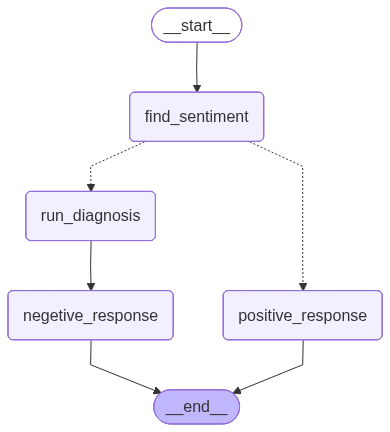

In [88]:
workflow

In [89]:
initial_state = {
    'review': "The product quality is terrible and the delivery was delayed. I'm very disappointed with my purchase.",
}
final_state = workflow.invoke(initial_state)
print(final_state)

{'review': "The product quality is terrible and the delivery was delayed. I'm very disappointed with my purchase.", 'sentiment': 'negetive', 'diagnosis': {'issue_type': 'Bug', 'tone': 'disappointed', 'urgency': 'high'}, 'response': AIMessage(content='Subject: Good News! Your Reported Bug Has Been Resolved - [Ticket ID/Issue Name]\n\nHi [User Name],\n\nI\'m truly sorry to hear you encountered a bug that caused disappointment, and I completely understand why you marked it as high urgency. We absolutely agree that critical issues need immediate attention, and we appreciate you bringing this to our attention.\n\nI\'m pleased to inform you that our team has successfully identified and deployed a fix for the bug you reported regarding [**briefly mention the specific bug if you know it, e.g., "the data not saving correctly," or "the login issue," otherwise just "the issue you experienced"**].\n\nYou should now find that [**describe the positive outcome, e.g., "the feature is working as expect